<a href="https://colab.research.google.com/github/ZakiyQirosM/GLAURA-model/blob/main/GlauraSeqModel_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile

import os

import random

import tensorflow as tf

import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import numpy as np

import seaborn as sns

import cv2

from tensorflow.keras import layers, models

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D

from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report

os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "2"

In [ ]:
dataset_path = '/kaggle/input/glaucoma-dataset-eyepacs-airogs-light-v2/eyepac-light-v2-512-jpg'

for main_folder in ['train', 'test', 'validation']:
    print(main_folder.upper())
    for sub_folder in ['RG', 'NRG']:
        folder_path = os.path.join(dataset_path, main_folder, sub_folder)
        num_files = len(os.listdir(folder_path))
        print(f"{sub_folder}: {num_files}")
    print("=================================")

TRAIN
RG: 4000
NRG: 4000
TEST
RG: 385
NRG: 385
VALIDATION
RG: 385
NRG: 385


# **DATA PREPROCESSING**

In [ ]:
BATCH_SIZE = 8
IMG_SIZE = (512, 512)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_path, 'train'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_path, 'validation'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_path, 'test'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 8000 files belonging to 2 classes.
Found 770 files belonging to 2 classes.
Found 770 files belonging to 2 classes.


In [ ]:
def preprocessing(image, label):
    image = (image - mean) / std
    return image, label

def augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Normalize
    image, label = preprocessing(image, label)

    return image, label

In [ ]:
train_ds = train_ds.map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)
validation_ds = validation_ds.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# modeling

In [ ]:
import tensorflow as tf

def Models(input_shape=(512, 512, 3)):
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=input_shape),

        tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(1024, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(512, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(2048, (3, 3), kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.GlobalAveragePooling2D(),

        tf.keras.layers.Dense(512, kernel_initializer='he_normal'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
model = Models()

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 510, 510, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 510, 510, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 510, 510, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 508, 508, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 508, 508, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 508, 508, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 506, 506, 256)  │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 506, 506, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 506, 506, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 253, 253, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 251, 251, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 251, 251, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 251, 251, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 249, 249, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 249, 249, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 249, 249, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 247, 247, 512)  │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 247, 247, 512)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 247, 247, 512)  │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 123, 123, 512)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 121, 121, 256)  │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 121, 121, 256)  │             

 Total params: 22,940,481 (87.51 MB)

 Trainable params: 22,928,961 (87.47 MB)

 Non-trainable params: 11,520 (45.00 KB)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)

In [ ]:
epochs = 50

In [ ]:
with tf.device('/device:GPU:0'):
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=validation_ds,
        callbacks=[early_stopping_callback, lr_scheduler]
    )

Epoch 1/50


I0000 00:00:1733316514.635951     104 service.cc:145] XLA service 0x784d78001ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733316514.636040     104 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733316595.463823     104 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_21', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 969s 881ms/step - accuracy: 0.5375 - loss: 0.8985 - val_accuracy: 0.6494 - val_loss: 0.7556 - learning_rate: 1.0000e-04
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 868s 868ms/step - accuracy: 0.5915 - loss: 0.6927 - val_accuracy: 0.6195 - val_loss: 0.6627 - learning_rate: 1.0000e-04
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 868s 868ms/step - accuracy: 0.6224 - loss: 0.6641 - val_accuracy: 0.5896 - val_loss: 0.6783 - learning_rate: 1.0000e-04
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 869s 869ms/step - accuracy: 0.6355 - loss: 0.6373 - val_accuracy: 0.6545 - val_loss: 0.6322 - learning_rate: 1.0000e-04
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 870s 869ms/step - accuracy: 0.6821 - loss: 0.5892 - val_accuracy: 0.7390 - val_loss: 0.5313 - learning_rate: 1.0000e-04
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 870s 870ms/step - accuracy: 0.7350 - loss: 0.5331 - val_accuracy: 0.5844 - val_loss: 0.8533 - learning_rate: 1.0000e-04
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━

Text(0, 0.5, 'Accuracys')

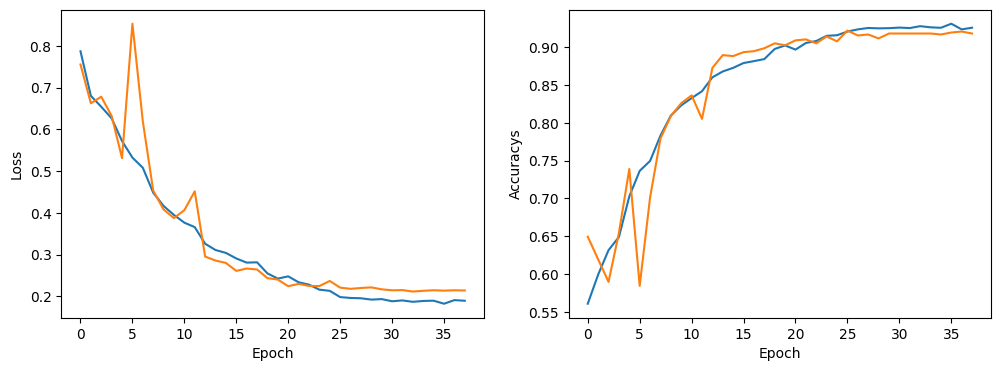

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracys')

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {accuracy * 100:.2f}%')

97/97 ━━━━━━━━━━━━━━━━━━━━ 27s 274ms/step - accuracy: 0.8955 - loss: 0.2976
Test accuracy: 89.87%


In [ ]:
def evaluate_model(model, test_ds):
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        predictions = model.predict(images, verbose=0)
        y_pred.extend(np.round(predictions).flatten())
        y_true.extend(labels.numpy().flatten())

    y_true = np.array(y_true, dtype=np.int32)
    y_pred = np.array(y_pred, dtype=np.int32)

    return y_true, y_pred

def generate_report(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["NRG", "RG"], yticklabels=["NRG", "RG"])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    report = classification_report(y_true, y_pred, target_names=["NRG", "RG"])
    print("Classification Report:")
    print(report)


In [ ]:
y_true, y_pred = evaluate_model(model, test_ds)

Confusion Matrix:
[[346  39]
 [ 39 346]]


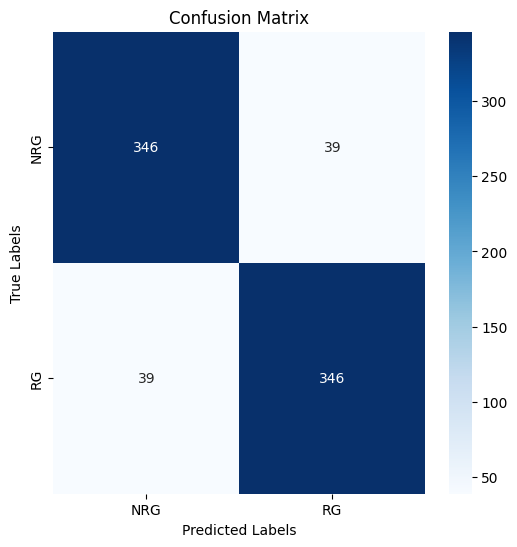

Classification Report:
              precision    recall  f1-score   support

         NRG       0.90      0.90      0.90       385
          RG       0.90      0.90      0.90       385

    accuracy                           0.90       770
   macro avg       0.90      0.90      0.90       770
weighted avg       0.90      0.90      0.90       770



In [ ]:
generate_report(y_true, y_pred)

In [ ]:
model.save("GlauraSeqModel.keras")

In [ ]:
from PIL import Image

def predict_image(model_path, image_path, class_names, target_size=(224, 224)):
    model = tf.keras.models.load_model(model_path)

    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

    predicted_class = class_names[1] if prediction[0][0] > 0.5 else class_names[0]
    confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]

    print(f"Prediksi: {predicted_class} (Confidence: {confidence:.4f})")


In [ ]:
model_path = '/kaggle/working/GlauraSeqModel.keras'
class_names = ['Non-Risk Group (NRG)', 'Risk Group (RG)']

In [ ]:
image_path = '/kaggle/input/new-test-data/drishtiGS_091.png'

predict_image(model_path, image_path, class_names)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/new-test-data/drishtiGS_091.png'

In [ ]:
image_path = '/kaggle/input/new-test-data/drishtiGS_048.png'

predict_image(model_path, image_path, class_names)